In [47]:
from stable_baselines3.common.atari_wrappers import AtariWrapper
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, VecTransposeImage
import pandas as pd
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
import numpy as np
import base64
import cv2
import torch
import os
import torch.nn.functional as F
import math
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist
import pickle
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.callbacks import EvalCallback

from sympy import latex
from IPython.display import display, Math

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.preprocessing import StandardScaler

np.math = math
gym.register_envs(ale_py)

# Cuda

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Establish Atari Enviornment

In [3]:
def make_RoadRunner_env():
  env = gym.make("RoadRunnerNoFrameskip-v4")
  env = AtariWrapper(env)
  return env

# Construct CNN-based Feature Extractors

In [8]:
class NatureCNN(BaseFeaturesExtractor):
    """
    Nature CNN feature extractor as in Mnih et al. (2015), used in SB3’s CnnPolicy/QNetwork.
    输出 feature vector 维度为 16

    :param observation_space: (gym.Space) 图像观测空间，形状 (C, H, W)
    :param features_dim: (int) 最后输出的特征维度，默认 16
    """
    def __init__(self, observation_space, features_dim: int = 16):
        super().__init__(observation_space, features_dim)

        # print(observation_space.shape)

        # 输入通道数 C
        n_input_channels = observation_space.shape[0]

        # print(n_input_channels)

        # 卷积 + ReLU + Flatten
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(start_dim=1)
        )

        # figure out size of the flattened CNN output
        with torch.no_grad():
            # 1) sample(): numpy ndarray, shape = (C, H, W)
            obs = observation_space.sample()
            # 2) 加 batch 维：(1, C, H, W)
            obs_tensor = torch.as_tensor(obs)[None].float()
            # 3) 获取压缩后的特征
            n_flatten = self.cnn(obs_tensor).shape[1]

            # print(n_flatten)

        # 三层全连接
        self.linear = nn.Sequential(
            nn.Linear(n_flatten, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, features_dim),
            nn.ReLU(),
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        # observations: [batch, C, H, W]
        x = self.cnn(observations)
        return self.linear(x)

# A2C


In [5]:
from stable_baselines3 import A2C

In [6]:
n_envs = 16
RoadRunner_env = DummyVecEnv([make_RoadRunner_env for _ in range(n_envs)])  # 用DummyVecEnv包装环境，使其并行
RoadRunner_env = VecTransposeImage(RoadRunner_env) # 转换成 (C, H, W) 而不是 (H, W, C)
RoadRunner_env = VecFrameStack(RoadRunner_env, n_stack=4)  # 堆叠帧，4帧堆叠

In [7]:
RoadRunner_env.observation_space.shape

(4, 84, 84)

# Establish A2C

In [11]:
policy_kwargs = dict(
    features_extractor_class=NatureCNN,
    features_extractor_kwargs=dict(features_dim=16),
    optimizer_class=RMSpropTFLike,
    optimizer_kwargs=dict(eps=1e-5)
)

n_timesteps = 10000000.0
ent_coef = 0.01
vf_coef = 0.25

A2C_model = A2C(
    policy="CnnPolicy",
    env=RoadRunner_env,
    policy_kwargs=policy_kwargs,
    verbose=1,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    tensorboard_log="./RoadRunner/a2c"
)

NameError: name 'RMSpropTFLike' is not defined

In [12]:
A2C_model.policy # 查看 A2C 算法模型架构

NameError: name 'A2C_model' is not defined

# Train A2C

In [10]:
eval_callback = EvalCallback(
    RoadRunner_env,
    best_model_save_path="./RoadRunner/a2c",
    log_path="./RoadRunner/a2c",   # tensorboard 或者 .csv 会写到这里
    eval_freq=100000,    # 每 10k 步评估一次
    n_eval_episodes=10,   # 每次评估跑 10 条完整 episode
    deterministic=True,   # 用确定性策略评估
    render=False,
)

A2C_model.learn(total_timesteps=int(n_timesteps), callback=eval_callback)

# 训练完成后保存模型
A2C_model.save("./RoadRunner/a2c")

Logging to ./RoadRunner/a2c\A2C_1
------------------------------------
| time/                 |          |
|    fps                | 474      |
|    iterations         | 100      |
|    time_elapsed       | 16       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -2.89    |
|    explained_variance | -8.97    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.0749   |
|    value_loss         | 0.00329  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 491      |
|    iterations         | 200      |
|    time_elapsed       | 32       |
|    total_timesteps    | 16000    |
| train/                |          |
|    entropy_loss       | -2.89    |
|    explained_variance | 0.0906   |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 0.0429   |
|   

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1600000, episode_reward=5.90 +/- 3.42
Episode length: 472.90 +/- 260.55
------------------------------------
| eval/                 |          |
|    mean_ep_length     | 473      |
|    mean_reward        | 5.9      |
| time/                 |          |
|    total_timesteps    | 1600000  |
| train/                |          |
|    entropy_loss       | -2.69    |
|    explained_variance | 0.291    |
|    learning_rate      | 0.0007   |
|    n_updates          | 19999    |
|    policy_loss        | 0.0202   |
|    value_loss         | 0.0427   |
------------------------------------
New best mean reward!
--------------------------------
| time/              |         |
|    fps             | 684     |
|    iterations      | 20000   |
|    time_elapsed    | 2337    |
|    total_timesteps | 1600000 |
--------------------------------
------------------------------------
| time/                 |          |
|    fps                | 684      |
|    iterations         | 2

# Load A2C Model

In [13]:
# 加载模型
A2C_model = A2C.load("./RoadRunner/a2c/best_model.zip")

# 设置 coef 为 0 来关闭探索，完全依赖于模型学到的策略
A2C_model.ent_coef = 0.0
A2C_model.vf_coef = 0.0

In [14]:
A2C_model.policy # 查看 A2C 算法模型架构

ActorCriticCnnPolicy(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=16, bias=True)
      (5): ReLU()
    )
  )
  (pi_features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (

In [15]:
A2C_features_extractor = A2C_model.policy.features_extractor
A2C_features_extractor

NatureCNN(
  (cnn): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (linear): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=16, bias=True)
    (5): ReLU()
  )
)

In [16]:
A2C_MlpExtractor = A2C_model.policy.mlp_extractor
A2C_MlpExtractor

MlpExtractor(
  (policy_net): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
  )
  (value_net): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
  )
)

In [17]:
A2C_ActionNet = A2C_model.policy.action_net
A2C_ValueNet = A2C_model.policy.value_net

In [18]:
A2C_ActionNet

Linear(in_features=64, out_features=18, bias=True)

In [19]:
A2C_ValueNet

Linear(in_features=64, out_features=1, bias=True)

# 输出每个状态下 16维特征 & 所有动作对应的Logits


In [20]:
def output_features_logits(obs):

  obs = torch.tensor(obs, dtype=torch.float32, device=device)

  features = A2C_features_extractor(obs)

  policy_values = A2C_MlpExtractor.policy_net(features)

  action_logits = A2C_ActionNet(policy_values)

  return features, action_logits

In [21]:
# 假设你的输入是一个形状为 (4, 84, 84) 的图像
input_tensor = torch.randn(1, 4, 84, 84).to(device)  # Batch size 1, 输入图像 (4, 84, 84)

features, action_logits = output_features_logits(input_tensor)

print(features)

print(action_logits)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14292\3246032145.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)


tensor([[0.1610, 0.0000, 0.9939, 1.1447, 0.7310, 0.0687, 3.2791, 4.7115, 0.0000,
         0.7207, 0.7615, 0.0000, 0.0000, 1.4792, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[ 0.7663, -1.0143,  7.2394, -2.2351,  1.1471, -3.9389, -2.2020,  6.0694,
         -2.7426, -2.2996,  0.3810, -1.8409, -0.9493, -1.5327, -0.7143, -0.7938,
         -1.8613, -1.2513]], device='cuda:0', grad_fn=<AddmmBackward0>)


# Collect Episode Data

In [22]:
n_envs = 1
RoadRunner_env = DummyVecEnv([make_RoadRunner_env for _ in range(n_envs)])  # 用DummyVecEnv包装环境，使其并行
RoadRunner_env = VecTransposeImage(RoadRunner_env) # 转换成 (C, H, W) 而不是 (H, W, C)
RoadRunner_env = VecFrameStack(RoadRunner_env, n_stack=4)  # 堆叠帧，4帧堆叠

In [42]:
# 确保输出目录存在
output_dir = "./RoadRunner/a2c/evaluation"
os.makedirs(output_dir, exist_ok=True)

num_episodes = 1000

# 为每个 episode 准备记录列表
episode_records = []
action_logits_records = []

# 列名生成，假设每个特征的列名为 f"feature_{i}"，其中 i 为特征编号
def generate_column_names(dimension):
    names = [f"feature_{i+1}" for i in range(dimension)]
    names.append("action")
    names.append("reward")
    return names

for ep in range(1, num_episodes + 1):
    obs = RoadRunner_env.reset()
    done = False

    # 清空记录列表
    episode_records.clear()
    action_logits_records.clear()

    while not done:
        # 提取状态的 特征值 和 动作值
        features, action_logits = output_features_logits(obs)

        features = features.squeeze(0).cpu().detach().numpy()
        action_logits = action_logits.squeeze(0).cpu().detach().numpy()

        # 使用A2C的 predict 方法来选择动作
        action, _states = A2C_model.predict(obs, deterministic=True)  # 选择最大 logits 值的动作

        next_obs, reward, done, info = RoadRunner_env.step(action)

        action_array = np.array([action])  # 将 action 转换为 NumPy 数组
        reward_array = np.array([reward])  # 将 reward 转换为 NumPy 数组

        # 确保 reward 和 action 也是一维数组
        action_array = action_array.flatten()
        reward_array = reward_array.flatten()

        # 合并所有数据到一起，确保它们是一个一维数组
        record = np.concatenate([features, action_array, reward_array])

        episode_records.append(record)
        action_logits_records.append(action_logits)

        obs = next_obs

    # 使用文件路径保存数据
    file_path = os.path.join(output_dir, f"episode_{ep}.csv")
    action_logits_file_path = os.path.join(output_dir, f"episode_{ep}_action_logits.txt")

    # 根据特征的维度生成列名
    column_names = generate_column_names(features.shape[0])  # 使用特征维度自动生成列名

    # 将数据转换为 DataFrame
    df = pd.DataFrame(episode_records, columns=column_names)

    # 保存为 CSV 文件
    df.to_csv(file_path, index=False)

    # 保存 action_logits 到 txt 文件
    with open(action_logits_file_path, 'a') as f:
        for action_logits in action_logits_records:
            action_logits_str = ",".join(map(str, action_logits.flatten()))  # 展平 action_probs 并将其转换为字符串
            f.write(f"{action_logits_str}\n")

    # 清空记录列表以备下一个 episode 使用
    episode_records.clear()
    action_logits_records.clear()

# Merge Episode

In [43]:
dim_16 = "./RoadRunner/a2c/evaluation"

def extract_episode_data(dim_dir, feature_dim, output_file):
    """
    提取每个 episode 的数据，并将结果存储到 CSV 文件
    Args:
        dim_dir (str): 目录路径
        feature_dim (int): 每个状态的特征维度（64, 36, 16）
        output_file (str): 最终合并结果保存的文件路径
    """
    episodes = []  # 存储每个 episode 数据

    # 如果文件已经存在，跳过
    if os.path.exists(output_file):
        print(f"{output_file} already exists. Skipping extraction.")
        return

    # 遍历目录中的每个 episode 文件
    for episode_file in os.listdir(dim_dir):
        if episode_file.endswith(".csv"):
            episode_name = episode_file.replace(".csv", "")  # 获取 episode 的基名
            action_logits_file = episode_name + "_action_logits.txt"  # 期望的 action_logits 文件名

            episode_path = os.path.join(dim_dir, episode_file)
            action_logits_path = os.path.join(dim_dir, action_logits_file)

            # 确保 action_logits 文件存在
            if os.path.exists(action_logits_path):
                # 读取 feature 数据 (states)
                df = pd.read_csv(episode_path)
                states = df[[f"feature_{i}" for i in range(1, feature_dim+1)]].values  # (T, feature_dim)

                # 读取 action_logits 数据
                action_logits = np.loadtxt(action_logits_path, delimiter=",")  # (T, n_actions)

                if action_logits.ndim == 1:
                    action_logits = action_logits.reshape(1, -1)  # 一行

                # 获取 max-action_logits 或者其他指定动作的 action_logits 值
                max_action_logits = np.max(action_logits, axis=1)  # 选择每个 state 的 max action_logits 值

                # 获取 max-action_logits 对应的 action (action_logits 的下标)
                actions = np.argmax(action_logits, axis=1)  # 每个 action_logits 对应的动作索引

                # 合并 states 和 max-action_logits 值
                episode_data = np.column_stack((states, max_action_logits, actions))
                episodes.append(episode_data)
            else:
                print(f"Missing action_logits file for {episode_name}, skipping...")

    # 将所有 episode 数据合并到一个 DataFrame 中并保存到文件
    all_episode_data = np.vstack(episodes)  # (T_total, feature_dim+1)
    columns = [f"feature_{i}" for i in range(1, feature_dim+1)] + ["max_action_logits", "action"]
    episode_df = pd.DataFrame(all_episode_data, columns=columns)
    episode_df.to_csv(output_file, index=False)
    print(f"Data extracted and saved to {output_file}")

# 逐个处理目录的数据
extract_episode_data(dim_16, 16, "./RoadRunner/a2c/eval_data.csv")

./RoadRunner/a2c/eval_data.csv already exists. Skipping extraction.


# Compute SHAP

In [23]:
# Step 1: Load and prepare the data
data = pd.read_csv('./RoadRunner/a2c/eval_data.csv')

X = data.drop(columns=['max_action_logits', 'action']).values
Y = data['max_action_logits'].values
Z = data['action'].values

X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
X_tensor[0]

tensor([  80.9117,    0.0000,    0.0000,  414.5998, 2241.8059,    0.0000,
         364.1568,    0.0000,    0.0000,  891.8977,    0.0000,    0.0000,
           0.0000, 1564.5344,    0.0000,   71.5301], device='cuda:0')

In [24]:
len(X_tensor)

298466

In [25]:
class ActionLogitFromFeatures(nn.Module):
    def __init__(self, mlp_extractor, action_net):
        super().__init__()
        self.policy_net = mlp_extractor.policy_net
        self.action_net = action_net

    def forward(self, state_features):
        x = self.policy_net(state_features)
        logits = self.action_net(x)
        return logits

In [26]:
A2C_PolicyActor = ActionLogitFromFeatures(A2C_MlpExtractor, A2C_ActionNet)
A2C_PolicyActor(X_tensor[0])

tensor([-0.6741, -1.2841, -4.6921, -4.9546,  5.5826, -1.3354, -4.6551,  4.5748,
        -3.6585,  7.9492, -1.0652, -1.1103,  0.0735, -0.9096, -1.0583, -0.2068,
        -1.3997,  1.2199], device='cuda:0', grad_fn=<ViewBackward0>)

In [25]:
background_size = int(len(X_tensor) * 0.01)  # Choose 1% of the data
background_data = X_tensor[:background_size]


# print(background_size)
# print(background_data.shape)

explainer = shap.DeepExplainer(A2C_PolicyActor, background_data)
shap_values = explainer.shap_values(X_tensor, check_additivity=False)

In [29]:
# 拿出各个维度
n_samples, n_features, n_actions = shap_values.shape
feature_names = data.drop(['max_action_logits','action'], axis=1).columns.tolist()

# 每个样本 j 的最大 action 索引
actions = Z.astype(int)           # shape = (n_samples,)
sample_idx = np.arange(n_samples) # [0,1,2,…,n_samples-1]

# fancy‐indexing：对每个样本 j，取 shap_arr[j, :, actions[j]] → (n_features,)
# 结果 shape = (n_samples, n_features)
shap_max = shap_values[sample_idx, :, actions]

# 构造输出 DataFrame
shap_df = pd.DataFrame(shap_max, columns=feature_names)
shap_df['max_action_logits'] = Y
shap_df['action']            = Z

# 保存到 CSV
out_path = './RoadRunner/a2c/shap_data.csv'
shap_df.to_csv(out_path, index=False)
print(f"[+] 已保存：{out_path}")

[+] 已保存：./RoadRunner/a2c/shap_data.csv


In [27]:
shap_data = pd.read_csv('./RoadRunner/a2c/shap_data.csv').drop(columns=['max_action_logits', 'action']).values
feature_names = pd.read_csv('./RoadRunner/a2c/shap_data.csv').drop(['max_action_logits','action'], axis=1).columns.tolist()

In [28]:
# 存储Shapley值到原始状态的映射
shapley_to_state_mapping = {}

# 遍历所有的样本，存储每个状态的 Shapley 向量与原始状态的映射
for i in range(len(X_tensor)):
    state = X[i]  # 获取原始状态 (假设你使用的是Tensor)
    shapley_vector = shap_data[i]  # 获取对应的Shapley值向量

    # 将Shapley向量和原始状态的映射保存在字典中
    shapley_to_state_mapping[tuple(shapley_vector)] = state

with open('./RoadRunner/a2c/shapley_to_state_mapping.pkl', 'wb') as f:
    pickle.dump(shapley_to_state_mapping, f)

print("Shapley向量到原始状态的映射已保存。")

Shapley向量到原始状态的映射已保存。


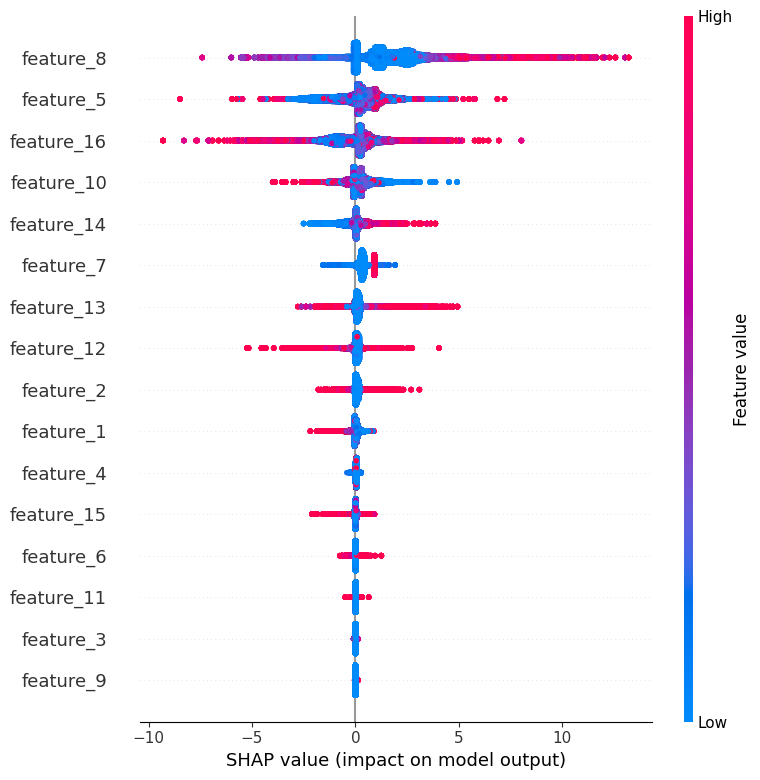

In [32]:
plt.figure(figsize=(10,10))
shap.summary_plot(shap_data, X, feature_names=feature_names)

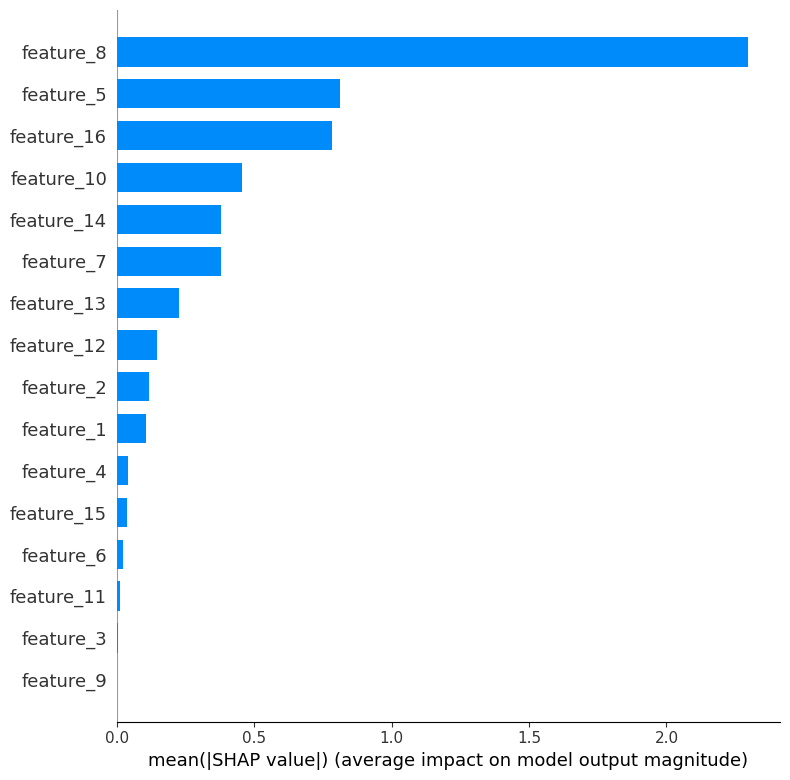

In [33]:
plt.figure(figsize=(10,10))
shap.summary_plot(shap_data, X, feature_names=feature_names, plot_type="bar")

In [29]:
shap_data[0]

array([ 2.35002823e-02,  5.41436598e-02, -1.22150278e-03, -3.57637376e-01,
        1.03504682e+00,  8.79424810e-03, -6.72090333e-04,  1.30140913e+00,
       -2.90122669e-04, -9.18588758e-01,  6.07492961e-03,  1.00648999e-01,
        3.60908546e-02,  2.43226743e+00,  4.67479974e-03, -1.01507783e+00])

In [30]:
print(shapley_to_state_mapping.get(tuple(shap_data[0])))

[  80.91173553    0.            0.          414.59976196 2241.8059082
    0.          364.15682983    0.            0.          891.89770508
    0.            0.            0.         1564.53442383    0.
   71.53011322]


# Action K-Means Clustering

In [29]:
n_actions = RoadRunner_env.action_space.n

kmeans = KMeans(n_clusters=n_actions)  # 根据动作数选择聚类数量
kmeans.fit(shap_data)

,n_clusters,np.int64(18)
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [30]:
# 获取每个样本的聚类标签
labels = kmeans.labels_

# 获取聚类中心
centroids = kmeans.cluster_centers_

print(f"Cluster Labels: {labels}")
print(f"Cluster Centroids: {centroids}")

Cluster Labels: [ 9 13 13 ...  0  0  0]
Cluster Centroids: [[-4.13391376e-02  1.26037668e-02 -9.89730462e-03  1.66063013e-02
   2.47529957e-01 -3.87786242e-03  8.21015344e-01  6.83384853e-02
  -8.92316420e-05 -6.40012875e-02  5.89081499e-04  1.52747472e-02
   1.19529654e-02  6.84729600e-02 -1.56612159e-03  2.37379039e-01]
 [ 4.77532549e-02  7.27132860e-02  1.74125316e-03  1.09267096e-01
   1.62813967e+00  1.28698750e-01  2.28524665e-01  7.69633236e+00
  -1.57452385e-04  4.30287928e-01  6.43720362e-02  3.06740001e-01
   4.37336780e-01  1.79446536e-01 -3.54852928e-03 -6.76874853e-01]
 [ 1.76595125e-01  9.52060130e-02  1.26570657e-02  1.86018241e-02
  -1.10639706e+00 -6.40564647e-04  2.73237353e-01  1.61501862e+00
  -2.21176295e-04 -9.18015489e-01 -1.11887527e-02  1.19019643e-01
   7.69707521e-02  1.46808455e-01 -2.02316883e-02 -8.83422024e-01]
 [-1.45022678e-01 -2.68305191e-02  3.35025213e-04  3.72599255e-02
   5.83499345e-01  2.03378157e-02  1.99955682e-01  1.03512844e+00
  -1.41710259e

# Boundary Points Identification

In [31]:
def find_boundary_points(shap_values, n_clusters):

    boundary_points = []

    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            # 计算每个样本到质心 i 和质心 j 的距离
            dist_to_centroids = cdist(shap_values, [centroids[i], centroids[j]], 'euclidean')
                
            # 找到距离差最小的样本，即边界点
            dist_diff = np.abs(dist_to_centroids[:, 0] - dist_to_centroids[:, 1])
            boundary_index = np.argmin(dist_diff)
                
            # 获取边界点
            boundary_point = shap_values[boundary_index]
            boundary_points.append((boundary_point, (i, j)))  # 存储边界点和对应的簇对

    # 返回所有的边界点和它们的簇对
    return boundary_points

# DNN approximates RL's behavior to qurey Boundary's actions

In [36]:
df = pd.read_csv("./RoadRunner/a2c/eval_data.csv")
scaler = StandardScaler()

# 提取输入特征和标签
X = df[[f"feature_{i}" for i in range(1, 17)]].values.astype(np.float32)
X = scaler.fit_transform(X)   # 每列特征 (feature1~feature16) 独立标准化到均值0、方差1

y = df["action"].values.astype(np.int64)

In [35]:
class FeatureDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = FeatureDataset(X, y)

train_loader = DataLoader(dataset, batch_size=512, shuffle=True)

In [36]:
class DNN(nn.Module):
    def __init__(self, input_dim=16, output_dim=18):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# 自动确定输出类别数
DNN_model = DNN().to(device)

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(DNN_model.parameters(), lr=1e-3)

In [38]:
num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    DNN_model.train()
    total_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        preds = DNN_model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_losses.append(total_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}]  Training Loss: {total_loss:.4f}")

Epoch [1/100]  Training Loss: 122.5872
Epoch [2/100]  Training Loss: 38.0360
Epoch [3/100]  Training Loss: 31.6311
Epoch [4/100]  Training Loss: 28.4954
Epoch [5/100]  Training Loss: 26.8152
Epoch [6/100]  Training Loss: 25.4019
Epoch [7/100]  Training Loss: 23.9846
Epoch [8/100]  Training Loss: 22.2742
Epoch [9/100]  Training Loss: 21.3367
Epoch [10/100]  Training Loss: 20.3709
Epoch [11/100]  Training Loss: 19.6617
Epoch [12/100]  Training Loss: 18.9647
Epoch [13/100]  Training Loss: 18.0893
Epoch [14/100]  Training Loss: 17.1629
Epoch [15/100]  Training Loss: 15.9386
Epoch [16/100]  Training Loss: 15.8775
Epoch [17/100]  Training Loss: 15.0933
Epoch [18/100]  Training Loss: 14.5915
Epoch [19/100]  Training Loss: 14.0427
Epoch [20/100]  Training Loss: 13.7953
Epoch [21/100]  Training Loss: 13.3346
Epoch [22/100]  Training Loss: 12.3603
Epoch [23/100]  Training Loss: 12.0673
Epoch [24/100]  Training Loss: 11.7121
Epoch [25/100]  Training Loss: 11.9223
Epoch [26/100]  Training Loss: 10

In [43]:
with torch.no_grad():
    sample_input = torch.tensor(X[0], dtype=torch.float32, device=device)
    sample_input = sample_input.unsqueeze(0)

    logits = DNN_model(sample_input)
    probs = torch.softmax(logits, dim=1) 
    action_label = torch.argmax(probs, dim=1).item()

print("Predicted action:", action_label)

Predicted action: 9


In [44]:
torch.save(DNN_model.state_dict(), "RoadRunner_A2C_DNN_.pth")
print("✅ Model saved as RoadRunner_A2C_DNN_.pth")

✅ Model saved as RoadRunner_A2C_DNN_.pth


# Inverse Shapley Values

In [45]:
# 调用函数寻找边界点
# 'shapley_vectors' 是已计算出的 SHAP 向量数据
boundary_points = find_boundary_points(shap_data, n_clusters=18)

# 创建一个列表来存储所有边界点的数据
# 每个元素将是一个包含 SHAP 向量和对应簇的编号的列表
boundary_data = []

# 创建一个列表来存储所有Inverse SHAP后的边界点的数据
shap_inverse_boundary_data = []

# 遍历每个边界点
for boundary_point, clusters in boundary_points:
    # 这里的 boundary_point 是一个 SHAP 向量，包含该边界点的所有特征
    # clusters 是一个元组，包含两个簇的编号 (cluster_1, cluster_2)

    i, j = clusters  # 两个簇编号

    # # 判断离哪个簇心更近，作为最终动作标签
    # dist_i = np.linalg.norm(boundary_point - centroids[i])
    # dist_j = np.linalg.norm(boundary_point - centroids[j])

    # if dist_i < dist_j:
    #     action_label = i
    # else:
    #     action_label = j

    # Inverse Shapley: 映射回原始状态
    shap_inverse_boundary_point = shapley_to_state_mapping.get(tuple(boundary_point))

    # print(shap_inverse_boundary_point)

    # ---------------- RL-Guided Labeling 核心部分 ----------------
    shap_inverse_boundary_point_scaled = scaler.transform(np.array(shap_inverse_boundary_point).reshape(1, -1))

    shap_inverse_boundary_point_tensor = torch.tensor(shap_inverse_boundary_point_scaled, dtype=torch.float32, device=device)

    with torch.no_grad():
        logits = DNN_model(shap_inverse_boundary_point_tensor)
        probs = torch.softmax(logits, dim=1) 
        action_label = torch.argmax(probs, dim=1).item()

    # 保存 SHAP 向量 + 簇编号 + 标签
    boundary_data.append(list(boundary_point) + [i, j, action_label])
    # 保存状态空间的边界点数据
    shap_inverse_boundary_data.append(list(shap_inverse_boundary_point) + [i, j, action_label])

# 计算每个边界点的特征列数
# 假设每个 SHAP 向量有 16 个特征
num_features = len(boundary_data[0]) - 3  # 减去 Cluster_1, Cluster_2, Action_Label

# 创建列名：Feature_1, Feature_2, ..., Feature_16 和 Cluster_1, Cluster_2, Action_Label
columns = [f"Feature_{k+1}" for k in range(num_features)] + ['Cluster_1', 'Cluster_2', 'Action_Label']

# 将边界点数据转换为 pandas DataFrame
boundary_df = pd.DataFrame(boundary_data, columns=columns)
shap_inverse_boundary_df = pd.DataFrame(shap_inverse_boundary_data, columns=columns)

# 保存 DataFrame 到 CSV 文件
boundary_df.to_csv('./RoadRunner/a2c/boundary_points.csv', index=False)
shap_inverse_boundary_df.to_csv('./RoadRunner/a2c/shap_inverse_boundary_points.csv', index=False)

In [31]:
bd_data = pd.read_csv('./RoadRunner/a2c/shap_inverse_boundary_points.csv')

# 提取特征（16个特征）
bd_X = bd_data.iloc[:, :-3].values  # 假设前16列是特征

# 提取标签
bd_Y = bd_data['Action_Label'].values  

In [32]:
bd_X[0]

array([ 161.50502014,    0.        ,    0.        ,    0.        ,
        849.9095459 ,    0.        ,    0.        , 1037.38525391,
          0.        ,  440.89178467,    0.        ,    0.        ,
          0.        ,  270.63540649,   56.4806633 ,  786.63555908])

In [33]:
bd_Y[0]

np.int64(7)

# Decision Boundary Regression using Decision Tree

In [48]:
# 创建决策树分类器
bd_DecisionTree = DecisionTreeClassifier(random_state=0)

# 训练模型
bd_DecisionTree.fit(bd_X, bd_Y)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [49]:
# 手动指定列名
feature_names = [f'Feature_{i+1}' for i in range(bd_X.shape[1])]
coefficient_names = [f'x{i+1}' for i in range(bd_X.shape[1])]

class_names = [str(i) for i in np.unique(bd_Y)]

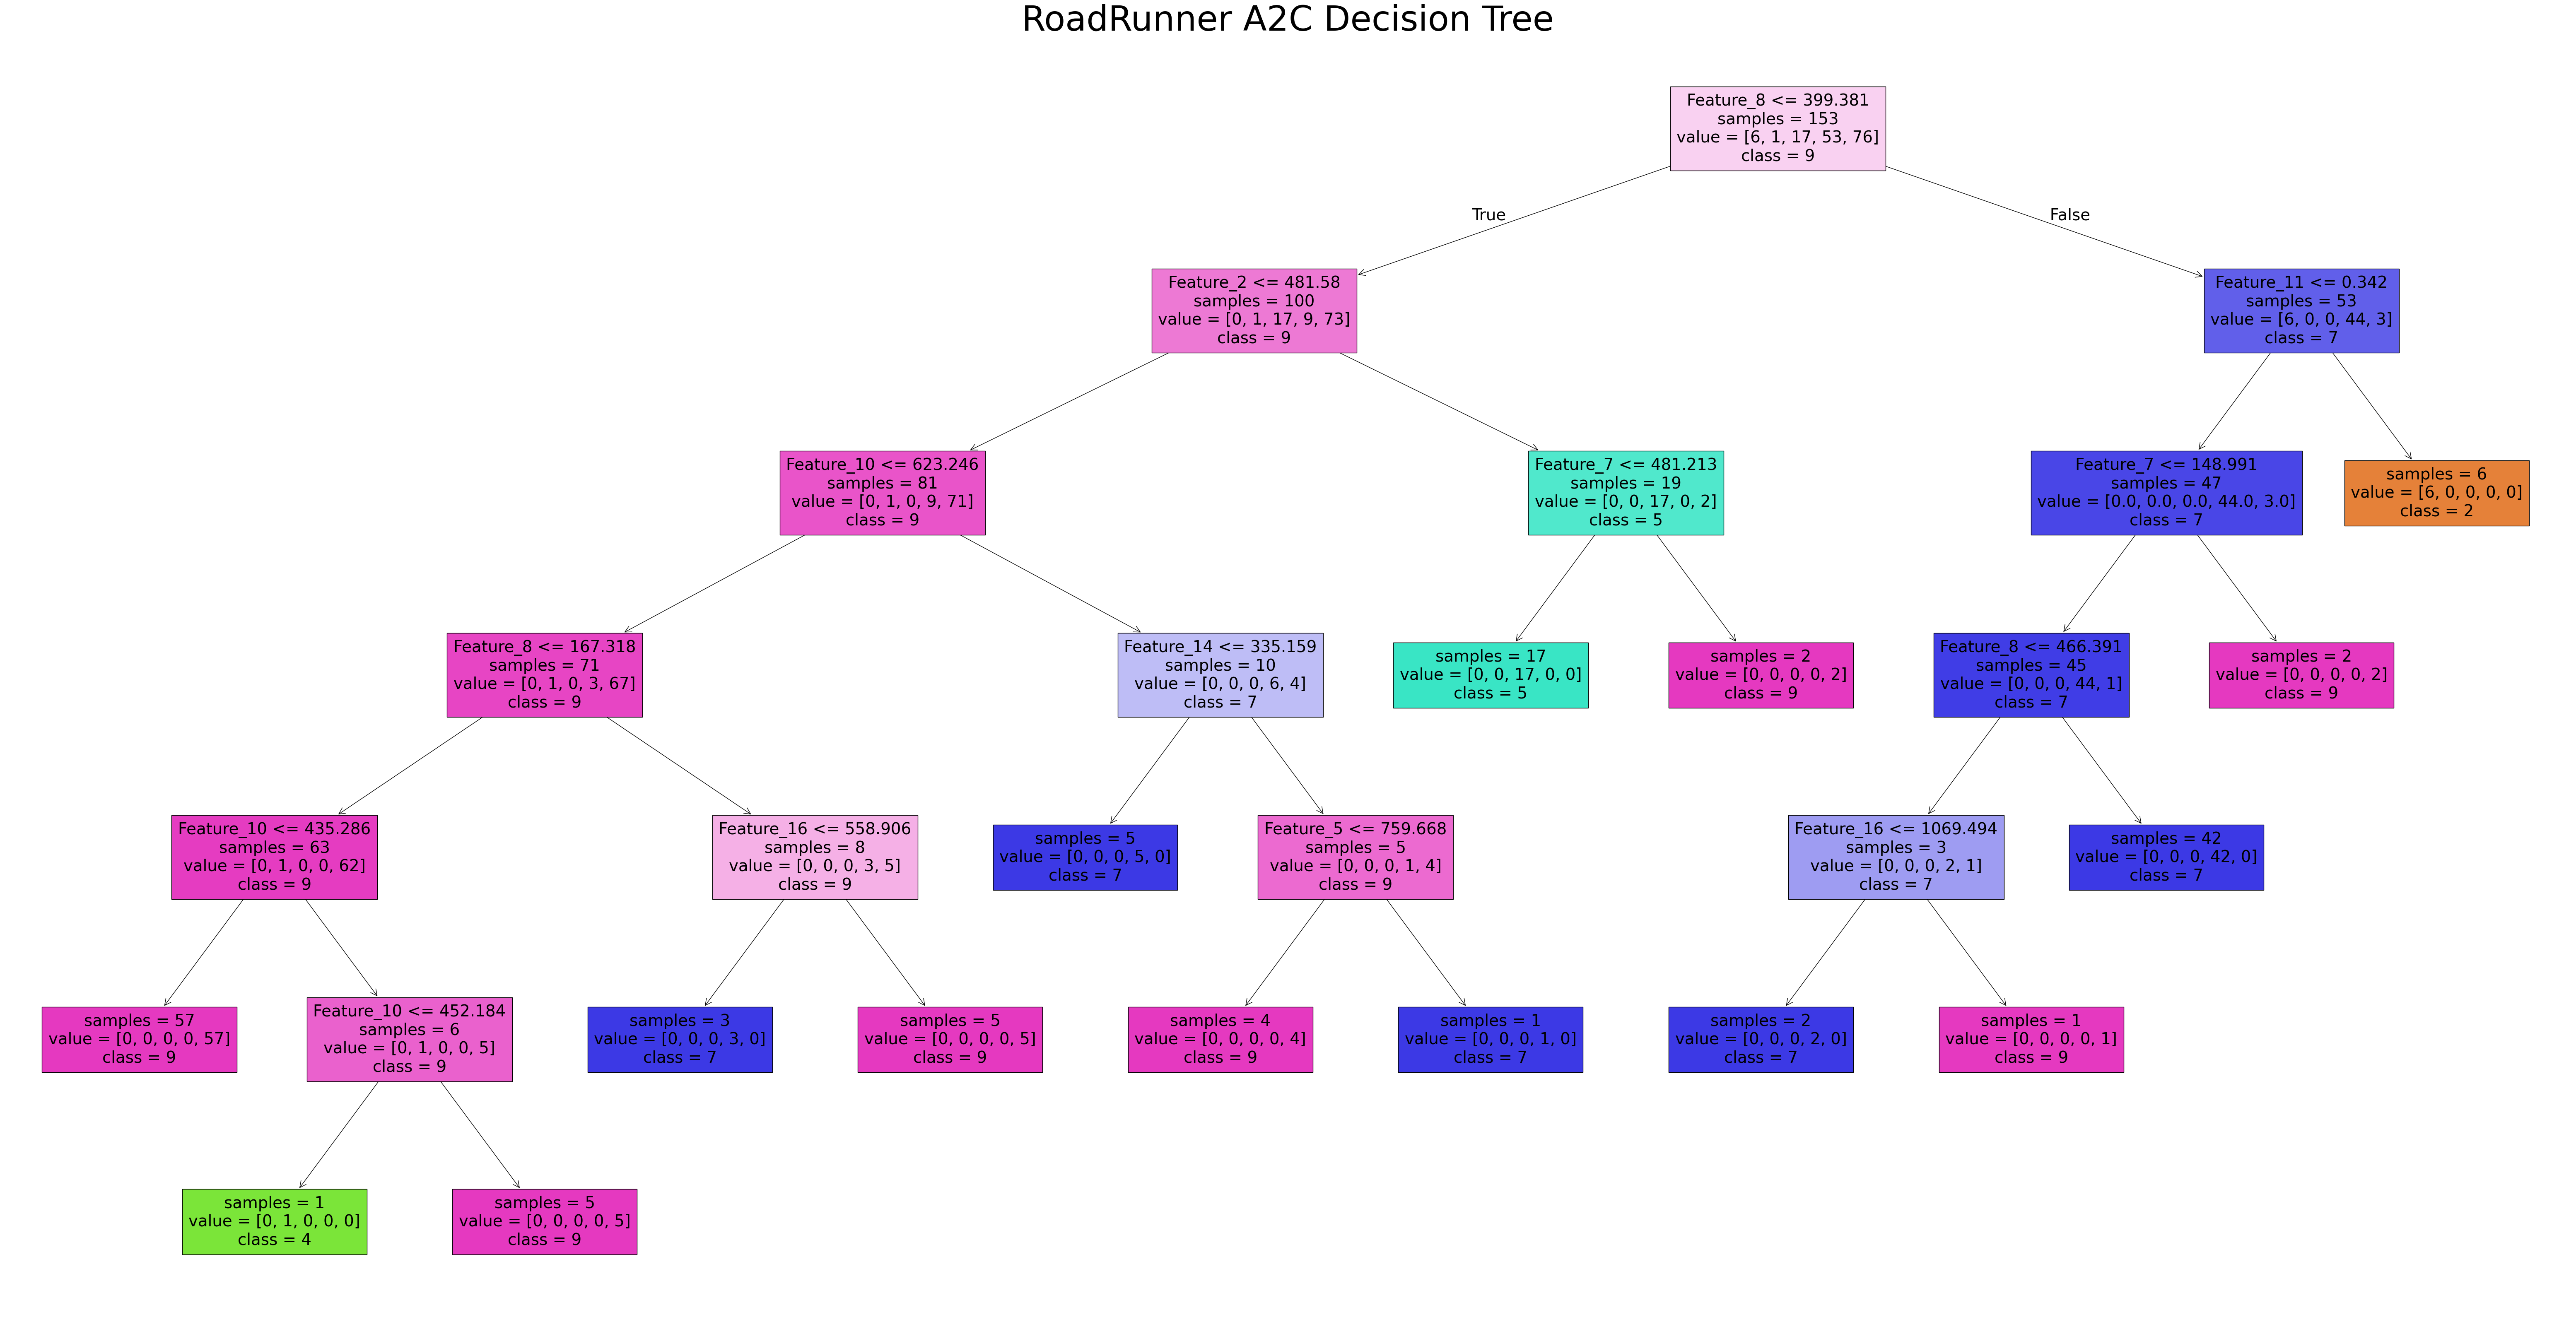

In [50]:
# Plot Decision Tree 
plt.figure(figsize=(80, 40))
plot_tree(bd_DecisionTree, feature_names=feature_names, class_names=class_names, filled=True, impurity = False) # 柔和蓝绿色调)
plt.title(r"RoadRunner A2C Decision Tree", fontsize=60)
plt.savefig("./RoadRunner/a2c/RoadRunner_a2c_decision_tree.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Decision Boundary Regression using Linear Regression

In [51]:
bd_LinearRegression = LinearRegression()

bd_LinearRegression.fit(bd_X, bd_Y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [52]:
# 封装函数：四舍五入 + 裁剪
def round_and_clip(predictions, min_value=0, max_value=8):
    # 四舍五入并裁剪到指定范围
    predictions_int = np.rint(predictions).astype(int)
    return np.clip(predictions_int, min_value, max_value)

In [53]:
def display_linear_formula(lr, feature_names, F_name='f1', tol=1e-16):
    """
    打印并返回线性打分公式：
      - 跳过 |coef| < tol 的特征
      - 正数前用 '+', 负数前用 '−'
    """
    coefs = lr.coef_.ravel()
    intercept = float(lr.intercept_)
    
    terms = []
    for w, name in zip(coefs, feature_names):
        # 忽略纯 0 或接近 0 的系数
        if abs(w) < tol:
            continue
        sign = "+" if w > 0 else "−"
        terms.append(f"{sign} {abs(w):.2e}·{name}")
    
    # 如果没有任何非零项，就只显示 intercept
    if not terms:
        formula = f"{F_name}(x) = {intercept:.2e}"
    else:
        formula = f"{F_name}(x) = {intercept:.2e} " + " ".join(terms)
    
    return formula

In [54]:
display_linear_formula(bd_LinearRegression, coefficient_names, F_name="f")

'f(x) = 8.82e+00 − 9.00e-04·x1 − 5.92e-03·x2 + 1.77e-03·x3 − 9.55e-03·x4 − 6.94e-04·x5 − 4.30e-03·x6 + 1.03e-04·x7 − 9.70e-04·x8 + 1.42e-02·x9 − 1.03e-03·x10 − 4.23e-03·x11 − 2.10e-03·x12 − 1.02e-04·x13 − 4.19e-04·x14 + 1.34e-03·x15 + 1.08e-03·x16'

# Decision Boundary Regression using Logistic Regression

In [55]:
bd_LogisticRegression = LogisticRegression(random_state=0, max_iter=10000, solver='saga', multi_class='multinomial')

bd_LogisticRegression.fit(bd_X, bd_Y)

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'saga'
,max_iter,10000
,multi_class,'multinomial'


In [56]:
def display_logistic_regression_formulas(lr, feature_names, action_names, model_name='f'):
    """
    给定 Logistic Regression 模型，输出每个动作（类别）对应的公式
    公式形式: f1(x) = intercept + Σ w_i * x_i
    """
    coefs = lr.coef_  # shape = (n_classes, n_features)
    intercepts = lr.intercept_  # shape = (n_classes,)
    
    for k, action_name in enumerate(action_names):
        terms = []
        for i, name in enumerate(feature_names):
            if coefs[k, i] >= 0:
                terms.append(f"+ {coefs[k, i]:.2e}·{name}")
            else:
                terms.append(f"− {abs(coefs[k, i]):.2e}·{name}")
        # 格式化公式
        formula = f"{model_name}_{action_name}(x) = {intercepts[k]:.2e} " + " ".join(terms)
        print(formula)

In [57]:
display_logistic_regression_formulas(bd_LogisticRegression, coefficient_names, class_names)

f_2(x) = -2.86e-06 − 1.35e-03·x1 + 1.61e-03·x2 − 1.98e-05·x3 + 1.56e-03·x4 − 1.17e-02·x5 + 3.76e-03·x6 − 6.08e-04·x7 + 1.83e-02·x8 − 3.67e-06·x9 − 1.45e-03·x10 + 2.28e-03·x11 + 8.55e-03·x12 + 6.14e-03·x13 − 2.22e-03·x14 − 2.16e-03·x15 − 8.77e-03·x16
f_4(x) = -5.35e-05 + 3.34e-03·x1 − 1.96e-03·x2 − 6.08e-04·x3 − 6.50e-05·x4 + 4.06e-03·x5 − 1.04e-03·x6 + 2.62e-03·x7 − 5.72e-03·x8 − 7.24e-06·x9 + 3.40e-03·x10 − 3.75e-05·x11 − 4.91e-03·x12 − 2.44e-03·x13 − 6.74e-03·x14 − 1.03e-03·x15 + 3.41e-03·x16
f_5(x) = -2.82e-05 − 7.23e-03·x1 + 1.14e-02·x2 − 1.97e-05·x3 − 1.84e-05·x4 − 6.60e-03·x5 − 1.41e-03·x6 − 6.26e-03·x7 − 8.87e-03·x8 + 2.14e-05·x9 − 7.41e-03·x10 − 5.33e-05·x11 − 3.18e-03·x12 + 7.26e-03·x13 + 1.81e-03·x14 + 2.15e-03·x15 + 3.50e-03·x16
f_7(x) = -1.50e-04 − 2.88e-03·x1 + 2.75e-03·x2 − 7.10e-04·x3 − 1.06e-03·x4 + 1.15e-02·x5 + 1.82e-03·x6 + 8.55e-03·x7 + 1.14e-02·x8 − 4.94e-05·x9 + 6.46e-03·x10 − 1.96e-03·x11 + 1.15e-02·x12 + 1.57e-03·x13 − 3.53e-03·x14 + 1.96e-03·x15 − 7.76e-03·x16


# Performance Evaluation

In [58]:
# 创建环境和执行episode的函数
def RL_run_episode(env, num_episodes, model):

    rewards = []

    for ep in range(num_episodes):
        obs = env.reset() 
        done = False
        total = 0

        while not done:
            action, _states = model.predict(obs, deterministic=True) 
            next_obs, reward, done, info = env.step(action)

            total += reward
            obs = next_obs       

        rewards.append(total)

    return rewards

def ML_run_episode(env, num_episodes, model):

    rewards = []

    for ep in range(num_episodes):
        obs = env.reset() 
        done = False
        total = 0

        while not done:
            # 提取状态的 特征值 和 动作值
            features, action_logits = output_features_logits(obs)

            features = features.squeeze(0).cpu().detach().numpy()
            action_logits = action_logits.squeeze(0).cpu().detach().numpy()

            action = model.predict([features]) 

            if isinstance(model, LinearRegression):
                action = round_and_clip(action)

            # print(action)

            next_obs, reward, done, info = env.step(action)

            total += reward
            obs = next_obs
        rewards.append(total)        

    return rewards

### A2C

In [77]:
A2C_result = RL_run_episode(RoadRunner_env, 100, A2C_model) 

print(A2C_result)
print(sum(A2C_result))

[array([0.], dtype=float32), array([0.], dtype=float32), array([75.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([79.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([87.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([77.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([75.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([75.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([84.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([89.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([75.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([83.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([83.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([7

In [82]:
A2C_result_np = np.array(A2C_result)
np.save("./RoadRunner/A2C_result.npy", A2C_result_np)

### Decision Tree

In [79]:
DT_result = ML_run_episode(RoadRunner_env, 130, bd_DecisionTree)

print(DT_result)
print(sum(DT_result))

[array([14.], dtype=float32), array([55.], dtype=float32), array([0.], dtype=float32), array([27.], dtype=float32), array([8.], dtype=float32), array([27.], dtype=float32), array([18.], dtype=float32), array([37.], dtype=float32), array([0.], dtype=float32), array([19.], dtype=float32), array([37.], dtype=float32), array([0.], dtype=float32), array([69.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([12.], dtype=float32), array([13.], dtype=float32), array([21.], dtype=float32), array([65.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([27.], dtype=float32), array([8.], dtype=float32), array([27.], dtype=float32), array([81.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([49.], dtype=float32), array([22.], dtype=float32), array([0.], dtype=float32), array([16.], dtype=float32), array([8.], dtype=float32), array([2.], dtype=float32), array([12.], dtype=float32), array([13.], dtype=float32)

In [83]:
DT_result_np = np.array(DT_result)
np.save("./RoadRunner/A2C_DT_result.npy", DT_result_np)

### Linear Regression

In [ ]:
LinearRegression_result = ML_run_episode(RoadRunner_env, 100, bd_LinearRegression)

print(LinearRegression_result)
print(sum(LinearRegression_result))

In [90]:
LinearRegression_result_np = np.array(LinearRegression_result)
np.save("./RoadRunner/A2C_LinearRegression_result.npy", LinearRegression_result_np)

### Logistic Regression

In [80]:
LogisticRegression_result = ML_run_episode(RoadRunner_env, 106, bd_LogisticRegression)

print(LogisticRegression_result)
print(sum(LogisticRegression_result))

[array([0.], dtype=float32), array([0.], dtype=float32), array([69.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([74.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([69.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([77.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([69.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([73.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([85.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([77.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([75.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([69.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([69.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([6

In [85]:
LogisticRegression_result_np = np.array(LogisticRegression_result)
np.save("./RoadRunner/A2C_LogisticRegression_result.npy", LogisticRegression_result_np)

# Fidelity Score Computation

In [64]:
num_episodes = 100

Decision_Tree_Fidelity = []
Linear_Regression_Fidelity = []
Logistic_Regression_Fidelity = []

for ep in range(num_episodes):
    obs = RoadRunner_env.reset() 
    done = False

    Decision_Tree_Count = 0
    Linear_Regression_Count = 0
    Logistic_Regression_Count = 0

    epoch = 0 

    while not done:
        action, _states = A2C_model.predict(obs, deterministic=True) 

        features, action_logits = output_features_logits(obs)
        features = features.squeeze(0).cpu().detach().numpy()

        Decision_Tree_action = bd_DecisionTree.predict([features]) 
        Linear_Regression_action = round_and_clip(bd_LinearRegression.predict([features]))
        Logistic_Regression_action = bd_LogisticRegression.predict([features])

        if Decision_Tree_action == action:
            Decision_Tree_Count += 1

        if Linear_Regression_action == action:
            Linear_Regression_Count += 1

        if Logistic_Regression_action == action:
            Logistic_Regression_Count += 1
        
        next_obs, reward, done, info = RoadRunner_env.step(action)

        obs = next_obs       
        epoch += 1

    Decision_Tree_Fidelity.append(Decision_Tree_Count/epoch)
    Linear_Regression_Fidelity.append(Linear_Regression_Count/epoch)
    Logistic_Regression_Fidelity.append(Logistic_Regression_Count/epoch)

In [60]:
Average_RoadRunner_A2C_Decision_Tree_Fidelity = sum(Decision_Tree_Fidelity)/len(Decision_Tree_Fidelity)

In [61]:
Average_RoadRunner_A2C_Linear_Regression_Fidelity = sum(Linear_Regression_Fidelity)/len(Linear_Regression_Fidelity)

In [62]:
Average_RoadRunner_A2C_Logistic_Regression_Fidelity = sum(Logistic_Regression_Fidelity)/len(Logistic_Regression_Fidelity)

In [63]:
results = {
    "Model": ["Decision Tree", "Linear Regression", "Logistic Regression"],
    "Average Fidelity": [
        Average_RoadRunner_A2C_Decision_Tree_Fidelity,
        Average_RoadRunner_A2C_Linear_Regression_Fidelity,
        Average_RoadRunner_A2C_Logistic_Regression_Fidelity
    ]
}

# 2️⃣ 转为 DataFrame
df = pd.DataFrame(results)

# 3️⃣ 保存到 CSV 文件（便于之后统一导入绘图）
df.to_csv("RoadRunner_A2C_Fidelity.csv", index=False)

print("✅ Fidelity results saved to RoadRunner_A2C_Fidelity.csv")

✅ Fidelity results saved to RoadRunner_A2C_Fidelity.csv
